In [1]:
import os

from projectaria_tools.core import data_provider, mps
from projectaria_tools.core.mps.utils import (
    filter_points_from_confidence,
    get_gaze_vector_reprojection,
    get_nearest_eye_gaze,
    get_nearest_pose,
)
from projectaria_tools.core.stream_id import StreamId
import numpy as np

# Load the VRS file
vrsfile = os.path.join("video1", "video1.vrs")

# Trajectory and global points
closed_loop_trajectory = os.path.join(
    "video1", "slam", "closed_loop_trajectory.csv"
)
global_points = os.path.join("video1", "slam", "semidense_points.csv.gz")

# Eye gaze
generalized_eye_gaze_path = os.path.join(
    "video1", "eyegaze", "general_eye_gaze.csv"
)

# Hand tracking
wrist_and_palm_poses_path = os.path.join(
    "video1", "hand_tracking", "wrist_and_palm_poses.csv"
)

# Create data provider and get T_device_rgb
provider = data_provider.create_vrs_data_provider(vrsfile)
# Since we want to display the position of the RGB camera, we are querying its relative location
# from the device and will apply it to the device trajectory.
T_device_RGB = provider.get_device_calibration().get_transform_device_sensor(
    "camera-rgb"
)

## Load trajectory and global points
mps_trajectory = mps.read_closed_loop_trajectory(closed_loop_trajectory)
points = mps.read_global_point_cloud(global_points)

## Load eyegaze
generalized_eye_gazes = mps.read_eyegaze(generalized_eye_gaze_path)

## Load hand tracking
wrist_and_palm_poses = mps.hand_tracking.read_wrist_and_palm_poses(
    wrist_and_palm_poses_path
)

# Loaded data must be not empty
assert(
    len(mps_trajectory) != 0 and
    len(points) != 0 and
    len(generalized_eye_gazes) != 0 and
    len(wrist_and_palm_poses) != 0)

[VRSIndexRecord][WARNING]: Seek to index record failed: DiskFile invalid offset
[RecordFileReader][WARNING]: Could not read index record: Index record error (#1021)
[RecordFileReader][WARNING]: Index incomplete. Rebuilding index of 'video1/video1.vrs'...
[VRSIndexRecord][WARNING]: Reindexing: record #694146 truncated. 64219 bytes missing out of 156531 bytes.
[VRSIndexRecord][INFO]: Record #694146 Header:
[VRSIndexRecord][INFO]: Record Size: 156531, expected 111
[VRSIndexRecord][INFO]: Previous Record Size: 111
[VRSIndexRecord][INFO]: Compression Type: 2
[VRSIndexRecord][INFO]: Uncompressed Size: 294920
[VRSIndexRecord][INFO]: Timestamp: 434.883532437
[VRSIndexRecord][INFO]: StreamId: Stereo Audio Class #1
[VRSIndexRecord][INFO]: Record Type: Data (3)
[VRSIndexRecord][INFO]: Format Version: 2
[VRSIndexRecord][INFO]: Indexing complete in 0.655 sec. Found 694146 records and 13 devices.
[MultiRecordFileReader][DEBUG]: Opened file 'video1/video1.vrs' and assigned to reader #0
[VrsDataProvid

Loaded #closed loop trajectory poses records: 362401
Loaded #3dPoints: 1679976
Loaded #EyeGazes: 3634
Loaded #WristAndPalmPose: 336


In [2]:
import plotly.graph_objs as go
from matplotlib import pyplot as plt

# Helper function to build the frustum
def build_cam_frustum(transform_world_device):
    points = (
        np.array(
            [[0, 0, 0], [0.5, 0.5, 1], [-0.5, 0.5, 1], [-0.5, -0.5, 1], [0.5, -0.5, 1]]
        )
        * 0.6
    )
    transform_world_rgb = transform_world_device @ T_device_RGB
    points_transformed = transform_world_rgb @ points.transpose()
    return go.Mesh3d(
        x=points_transformed[0, :],
        y=points_transformed[1, :],
        z=points_transformed[2, :],
        i=[0, 0, 0, 0, 1, 1],
        j=[1, 2, 3, 4, 2, 3],
        k=[2, 3, 4, 1, 3, 4],
        showscale=False,
        visible=False,
        colorscale="jet",
        intensity=points[:, 2],
        opacity=1.0,
        hoverinfo="none",
    )

In [3]:
# # Load all world positions from the trajectory
# traj = np.empty([len(mps_trajectory), 3])
# for i in range(len(mps_trajectory)):
#     traj[i, :] = mps_trajectory[i].transform_world_device.translation()

# # Subsample trajectory for quick display
# skip = 1000
# mps_trajectory_subset = mps_trajectory[::skip]
# steps = [None]*len(mps_trajectory_subset)

# # Load each pose as a camera frustum trace
# cam_frustums = [None]*len(mps_trajectory_subset)

# for i in range(len(mps_trajectory_subset)):
#     pose = mps_trajectory_subset[i]
#     cam_frustums[i] = build_cam_frustum(pose.transform_world_device)
#     timestamp = pose.tracking_timestamp.total_seconds()
#     step = dict(method="update", args=[{"visible": [False] * len(cam_frustums) + [True] * 2}, {"title": "Trajectory and Point Cloud"},], label=timestamp,)
#     step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
#     steps[i] = step
# cam_frustums[0].visible = True
    
# # Filter the point cloud by inv depth and depth and load
# points = filter_points_from_confidence(points)
# # Retrieve point position
# point_cloud = np.stack([it.position_world for it in points])

# # Create slider to allow scrubbing and set the layout
# sliders = [dict(currentvalue={"suffix": " s", "prefix": "Time :"}, pad={"t": 5}, steps=steps,)]
# layout = go.Layout(sliders=sliders, scene=dict(bgcolor='lightgray', dragmode='orbit', aspectmode='data', xaxis_visible=False, yaxis_visible=False,zaxis_visible=False))

# # Plot trajectory and point cloud
# # We color the points by their z coordinate
# trajectory = go.Scatter3d(x=traj[:, 0], y=traj[:, 1], z=traj[:, 2], mode="markers", marker={"size": 2, "opacity": 0.8, "color": "red"}, name="Trajectory", hoverinfo='none')
# global_points = go.Scatter3d(x=point_cloud[:, 0], y=point_cloud[:, 1], z=point_cloud[:, 2], mode="markers",
#     marker={"size" : 1.5, "color": point_cloud[:, 2], "cmin": -1.5, "cmax": 2, "colorscale": "viridis",},
#     name="Global Points", hoverinfo='none')

# # draw
# plot_figure = go.Figure(data=cam_frustums + [trajectory, global_points], layout=layout)
# plot_figure.show()

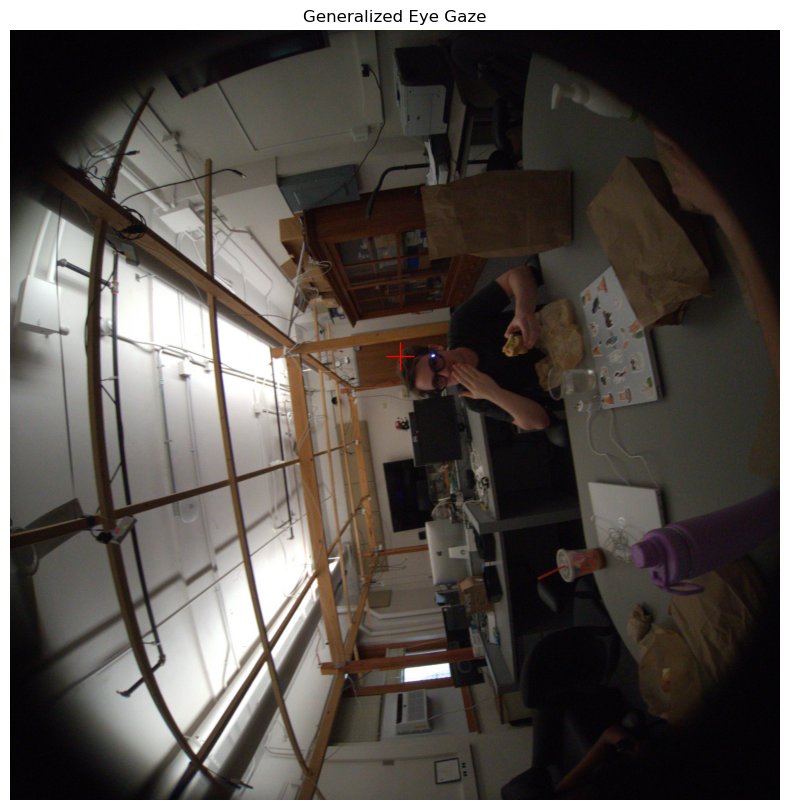

In [4]:
rgb_stream_id = StreamId("214-1")
rgb_stream_label = provider.get_label_from_stream_id(rgb_stream_id)
num_rgb_frames = provider.get_num_data(rgb_stream_id)
rgb_frame = provider.get_image_data_by_index(rgb_stream_id, (int)(num_rgb_frames-5))
assert rgb_frame[0] is not None, "no rgb frame"

image = rgb_frame[0].to_numpy_array()
capture_timestamp_ns = rgb_frame[1].capture_timestamp_ns
generalized_eye_gaze = get_nearest_eye_gaze(generalized_eye_gazes, capture_timestamp_ns)
# get projection function
device_calibration = provider.get_device_calibration()
cam_calibration = device_calibration.get_camera_calib(rgb_stream_label)
assert cam_calibration is not None, "no camera calibration"

fig, (ax1) = plt.subplots(1, 1, figsize=(12, 10))

# Draw a cross at the projected gaze center location on the RGB image at available depth or if unavailable a 1m proxy
depth_m = generalized_eye_gaze.depth or 1.0
generalized_gaze_center_in_pixels = get_gaze_vector_reprojection(generalized_eye_gaze, rgb_stream_label, device_calibration, cam_calibration, depth_m)
if generalized_gaze_center_in_pixels is not None:
    ax1.imshow(image)
    ax1.plot(generalized_gaze_center_in_pixels[0], generalized_gaze_center_in_pixels[1], '+', c="red", mew=1, ms=20)
    ax1.grid(False)
    ax1.axis(False)
    ax1.set_title("Generalized Eye Gaze")
else:
    print(f"Eye gaze center projected to {generalized_gaze_center_in_pixels}, which is out of camera sensor plane.")


plt.show()


In [7]:
from projectaria_tools.core import data_provider, calibration
from projectaria_tools.core.stream_id import StreamId

#vrsfile = "example.vrs"
provider = data_provider.create_vrs_data_provider(vrsfile)

# returns None if vrs does not have a calibration
device_calib = provider.get_device_calibration()
print(device_calib.get_device_subtype())

DVT-S


[VRSIndexRecord][WARNING]: Seek to index record failed: DiskFile invalid offset
[RecordFileReader][WARNING]: Could not read index record: Index record error (#1021)
[RecordFileReader][WARNING]: Index incomplete. Rebuilding index of 'video1/video1.vrs'...
[VRSIndexRecord][WARNING]: Reindexing: record #694146 truncated. 64219 bytes missing out of 156531 bytes.
[VRSIndexRecord][INFO]: Record #694146 Header:
[VRSIndexRecord][INFO]: Record Size: 156531, expected 111
[VRSIndexRecord][INFO]: Previous Record Size: 111
[VRSIndexRecord][INFO]: Compression Type: 2
[VRSIndexRecord][INFO]: Uncompressed Size: 294920
[VRSIndexRecord][INFO]: Timestamp: 434.883532437
[VRSIndexRecord][INFO]: StreamId: Stereo Audio Class #1
[VRSIndexRecord][INFO]: Record Type: Data (3)
[VRSIndexRecord][INFO]: Format Version: 2
[VRSIndexRecord][INFO]: Indexing complete in 0.698 sec. Found 694146 records and 13 devices.
[MultiRecordFileReader][DEBUG]: Opened file 'video1/video1.vrs' and assigned to reader #0
[VrsDataProvid

In [8]:
label = "camera-slam-right"
transform_device_sensor = device_calib.get_transform_device_sensor(label)
transform_device_cpf = device_calib.get_transform_device_cpf()
transform_cpf_sensor = device_calib.get_transform_cpf_sensor(label)
cam_calib = device_calib.get_camera_calib(label)
print(cam_calib)

CameraCalibration(label: camera-slam-right, model name: Fisheye624, principal point: [318.223, 239.021], focal length: [241.585, 241.585], projection params: [241.585, 318.223, 239.021, -0.023426, 0.0943243, -0.0607366, 0.00436108, 0.00408, -0.0007908, 0.000127869, -0.00152421, -0.000474396, 0.000183744, 0.00279317, 0.000168319], image size (w,h): [640, 480], T_Device_Camera:(translation:[0.0037926, -0.108767, -0.0849426], quaternion(x,y,z,w):[0.614966, -0.00130343, 0.0335465, 0.787838]), serialNumber:0072510f1b2100050300001606210001)


In [42]:
cam_calib = device_calib.get_camera_calib(label)
print(cam_calib)
print(dir(cam_calib))
print(cam_calib.get_focal_lengths())
print(cam_calib.get_principal_point())
print(cam_calib.get_transform_device_camera())
print(cam_calib.projection_params)
            
            
            
pinhole = calibration.get_linear_camera_calibration(512, 512, 150)
print(pinhole.get_focal_lengths())
print(pinhole.get_principal_point())
print(pinhole.get_transform_device_camera())
print(pinhole.projection_params)


CameraCalibration(label: camera-slam-right, model name: Fisheye624, principal point: [318.223, 239.021], focal length: [241.585, 241.585], projection params: [241.585, 318.223, 239.021, -0.023426, 0.0943243, -0.0607366, 0.00436108, 0.00408, -0.0007908, 0.000127869, -0.00152421, -0.000474396, 0.000183744, 0.00279317, 0.000168319], image size (w,h): [640, 480], T_Device_Camera:(translation:[0.0037926, -0.108767, -0.0849426], quaternion(x,y,z,w):[0.614966, -0.00130343, 0.0335465, 0.787838]), serialNumber:0072510f1b2100050300001606210001)
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'get_focal_lengths', 'get_image_size', 'get_label', 'get_principal_point', 'get_serial_number', 'get_transform_device_camera', 'is_visible', 

In [10]:
import numpy as np
import cv2

def undistort_point(x_distorted, y_distorted, K, dist_coeffs, new_K, original_size, new_size):
    # Convert the point to the format required by cv2.undistortPoints
    distorted_points = np.array([[x_distorted, y_distorted]], dtype=np.float32)
    
    # Undistort the points (map to normalized coordinates)
    undistorted_points = cv2.undistortPoints(distorted_points, K, dist_coeffs, P=new_K)
    
    # Convert normalized coordinates back to pixel coordinates
    undistorted_points = undistorted_points[0][0]
    x_undistorted = undistorted_points[0]
    y_undistorted = undistorted_points[1]
    
    # Scale the undistorted point to the new image size
    scale_x = new_size[0] / original_size[0]
    scale_y = new_size[1] / original_size[1]
    x_undistorted *= scale_x
    y_undistorted *= scale_y
    
    return [x_undistorted, y_undistorted]

# Original intrinsic camera matrix (K) for 640x480 image
K = np.array([
    [241.585, 0, 318.223],
    [0, 241.585, 239.021],
    [0, 0, 1]
], dtype=np.float32)

# Distortion coefficients
dist_coeffs = np.array([-0.023426, 0.0943243, -0.0607366, 0.00436108, 0.00408, -0.0007908, 0.000127869, -0.00152421, -0.000474396, 0.000183744, 0.00279317, 0.000168319], dtype=np.float32)

# New image size (512x512)
new_size = (512, 512)
original_size = (640, 480)

# Adjust the new camera matrix (new_K) for the 512x512 image
new_K = K.copy()
new_K[0, 0] *= new_size[0] / original_size[0]  # fx scaling
new_K[1, 1] *= new_size[1] / original_size[1]  # fy scaling
new_K[0, 2] = new_size[0] / 2  # new cx
new_K[1, 2] = new_size[1] / 2  # new cy

# Coordinates of the point in the distorted image
x_distorted = 320  # Example x coordinate
y_distorted = 240  # Example y coordinate

# Get the undistorted point coordinates
[x_undistorted, y_undistorted] = undistort_point(x_distorted, y_distorted, K, dist_coeffs, new_K, original_size, new_size)

print("Distorted point:", (x_distorted, y_distorted))
print("Undistorted point:", (x_undistorted, y_undistorted))

Distorted point: (320, 240)
Undistorted point: (205.937744140625, 274.1821614583333)


In [45]:
import numpy as np
import cv2

# Intrinsic parameters for the undistorted (pinhole) camera
K_pinhole = np.array([
    [150, 0, 255.5],
    [0, 150, 255.5],
    [0, 0, 1]
])

# Projection matrices for both cameras (original distorted fisheye and undistorted pinhole)
P1 = K_pinhole @ np.hstack((np.eye(3), np.zeros((3, 1))))
P2 = K_pinhole @ np.hstack((np.array([
    [0.99774587, 0.05125527, 0.04331368],
    [-0.05446153, 0.24138238, 0.96890066],
    [0.03920611, -0.96907556, 0.24362971]
]), np.array([0.00547003, 0.10876203, -0.08485794]).reshape(3, 1)))

# Extrinsics for the left (undistorted pinhole) camera
R_left = np.eye(3)
t_left = np.zeros((3, 1))

# Extrinsics for the right (undistorted pinhole) camera
R_right = np.array([
    [0.99774587, 0.05125527, 0.04331368],
    [-0.05446153, 0.24138238, 0.96890066],
    [0.03920611, -0.96907556, 0.24362971]
])

t_right = np.array([0.00547003, 0.10876203, -0.08485794]).reshape(3, 1)

def image_to_ndc(image_point, focal_lengths, principal_point):
    return (image_point - principal_point) / focal_lengths

def distance_stereo(x_cam1, y_cam1, x_cam2, y_cam2):
    # Convert image coordinates to normalized device coordinates (NDC)
    point_ndc_cam1 = np.array([x_cam1, y_cam1], dtype=np.float32).reshape(2, 1)
    point_ndc_cam2 = np.array([x_cam2, y_cam2], dtype=np.float32).reshape(2, 1)

    # Triangulate 3D point
    points_4d = cv2.triangulatePoints(P1, P2, point_ndc_cam1, point_ndc_cam2)

    # Convert homogeneous coordinates to Cartesian coordinates
    points_3d = points_4d[:3] / points_4d[3]
    
    # Calculate distance from the midpoint of the two cameras
    midpoint = (t_left.flatten() + t_right.flatten()) / 2
    distance_to_midpoint = np.linalg.norm(points_3d.flatten() - midpoint)
    
    return distance_to_midpoint

# Example usage with undistorted image coordinates
x_cam1_undistorted = 100  # Example x coordinate from left camera undistorted
y_cam1_undistorted = 150  # Example y coordinate from left camera undistorted
x_cam2_undistorted = 102  # Example x coordinate from right camera undistorted
y_cam2_undistorted = 148  # Example y coordinate from right camera undistorted

depth = distance_stereo(x_cam1_undistorted, y_cam1_undistorted, x_cam2_undistorted, y_cam2_undistorted)
print("Estimated distance to midpoint:", depth)


Estimated distance to midpoint: 0.08323744157461664


In [44]:
import numpy as np
import cv2

# Access the 6DoF poses for the two cameras
transform_camera_device_left = np.array([
    [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, -1.38777878e-17],
    [0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
])

transform_camera_device_right = np.array([
    [ 0.99774587,  0.05125527,  0.04331368,  0.00547003],
    [-0.05446153,  0.24138238,  0.96890066,  0.10876203],
    [ 0.03920611, -0.96907556,  0.24362971, -0.08485794],
    [ 0.          ,0.          , 0.          , 1.        ]
])

focal_lengths_left = np.array([241.94337696, 241.94337696])
principal_point_left = np.array([318.84485501, 239.45796664])

focal_lengths_right = np.array([241.94337696, 241.94337696])
principal_point_right = np.array([318.84485501, 239.45796664])

# Intrinsic matrix for left camera
K_left = np.array([
    [focal_lengths_left[0], 0, principal_point_left[0]],
    [0, focal_lengths_left[1], principal_point_left[1]],
    [0, 0, 1]
])

# Intrinsic matrix for right camera
K_right = np.array([
    [focal_lengths_right[0], 0, principal_point_right[0]],
    [0, focal_lengths_right[1], principal_point_right[1]],
    [0, 0, 1]
])

# Projection matrices (intrinsic * extrinsic)
P1 = K_left @ transform_camera_device_left[:3]
P2 = K_right @ transform_camera_device_right[:3]

# Function to convert image coordinates to normalized device coordinates (NDC)
def image_to_ndc(image_point, focal_lengths, principal_point):
    return (image_point - principal_point) / focal_lengths

# Function to calculate the distance using triangulation
def distance_stereo_distorted(x_cam1, y_cam1, x_cam2, y_cam2):
    # Convert image coordinates to normalized device coordinates (NDC)
    point_ndc_cam1 = image_to_ndc(np.array([x_cam1, y_cam1]), focal_lengths_left, principal_point_left)
    point_ndc_cam2 = image_to_ndc(np.array([x_cam2, y_cam2]), focal_lengths_right, principal_point_right)
    
    # Format points correctly
    point_ndc_cam1 = np.array([x_cam1, y_cam1], dtype=np.float32).reshape(2, 1)
    point_ndc_cam2 = np.array([x_cam2, y_cam2], dtype=np.float32).reshape(2, 1)

    # Triangulate 3D point
    points_4d = cv2.triangulatePoints(P1, P2, point_ndc_cam1, point_ndc_cam2)

    # Convert homogeneous coordinates to Cartesian coordinates
    points_3d = points_4d[:3] / points_4d[3]
    
    # Calculate distance from the midpoint of the two cameras
    midpoint = (transform_camera_device_left[:3, 3] + transform_camera_device_right[:3, 3]) / 2
    distance_to_midpoint = np.linalg.norm(points_3d.flatten() - midpoint)
    
    return distance_to_midpoint

# Example usage
x_cam1 = 100  # Example x coordinate from left camera
y_cam1 = 150  # Example y coordinate from left camera
x_cam2 = 102  # Example x coordinate from right camera
y_cam2 = 148  # Example y coordinate from right camera

depth = distance_stereo(x_cam1, y_cam1, x_cam2, y_cam2)
print("Estimated distance to midpoint:", depth)

Estimated distance to midpoint: 0.09414799173397564


In [37]:
import cv2
import os
import subprocess

def eye_gaze(capture_timestamp_ns,image,slam_stream_label,cam_calibration):
    generalized_eye_gaze = get_nearest_eye_gaze(generalized_eye_gazes, capture_timestamp_ns)
    depth, combined_yaw, combined_pitch = (
        mps.compute_depth_and_combined_gaze_direction(
            generalized_eye_gaze.vergence.left_yaw, generalized_eye_gaze.vergence.right_yaw, generalized_eye_gaze.pitch
        )
    )
    depth_m = depth or 1.0
    generalized_gaze_center_in_pixels = get_gaze_vector_reprojection(generalized_eye_gaze, slam_stream_label, device_calibration, cam_calibration, depth_m)
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    if generalized_gaze_center_in_pixels is not None:
        # Draw a red cross on the image at the gaze center
        marker_position = [(generalized_gaze_center_in_pixels[0]), (generalized_gaze_center_in_pixels[1])]
        return marker_position, image_color
    else:
        print(f"Eye gaze center projected to {generalized_gaze_center_in_pixels}, which is out of camera sensor plane.")
        return None, image_color

import numpy as np

def inverse_warp(marker1, pinhole, cam1_calibration):
    # Convert the pixel coordinate to float and reshape it as needed
    marker1_float = np.array(marker1, dtype=float).reshape(2, 1)  # Reshape to (2, 1)
    
    # Unproject the pixel coordinate using the destination calibration parameters (pinhole)
    ray_dir = pinhole.unproject_no_checks(marker1_float.astype(np.double))
    
    # Project the ray direction onto the source image plane using the source calibration parameters (cam1_calibration)
    maybe_src_pixel = cam1_calibration.project(ray_dir)
    
    if maybe_src_pixel is not None:  # Check if maybe_src_pixel is not None before calling .any()
        if maybe_src_pixel.any():  # Check if any elements are non-zero or non-empty
            # Convert the projected pixel coordinate back to float and reshape it as needed
            src_pixel_float = maybe_src_pixel.astype(float).reshape(2,)  # Reshape to (2,)
            return src_pixel_float
    
    return None  # Return None if maybe_src_pixel is None or empty

def correct_point(green_point, red_point):
    green_point = np.array(green_point)
    red_point = np.array(red_point)
    
    # Calculate the direction vector from green to red
    direction_vector = red_point - green_point
    
    # Calculate the distance between green and red points
    distance = np.linalg.norm(direction_vector)
    
    # Normalize the direction vector
    unit_vector = direction_vector / distance
    
    # Extend the green point along the direction vector by the same distance
    corrected_point = red_point + unit_vector * distance
    
    return corrected_point


output_dir = "images"

slam_stream_id = StreamId("1201-1")
slam_stream_id2 = StreamId("1201-2")

slam_stream_label = provider.get_label_from_stream_id(slam_stream_id)
slam_stream_label2 = provider.get_label_from_stream_id(slam_stream_id2)

num_slam_frames = provider.get_num_data(slam_stream_id)
num_slam_frames = min(num_slam_frames, provider.get_num_data(slam_stream_id2))

slam_frame = provider.get_image_data_by_index(slam_stream_id, (int)(1))
assert slam_frame[0] is not None, "no slam frame"
slam_frame2 = provider.get_image_data_by_index(slam_stream_id2, (int)(1))
assert slam_frame2[0] is not None, "no slam frame"

# get projection function
device_calibration = provider.get_device_calibration()
cam1_calibration = device_calibration.get_camera_calib(slam_stream_label)
cam2_calibration = device_calibration.get_camera_calib(slam_stream_label2)
assert cam1_calibration is not None, "no camera calibration"
assert cam2_calibration is not None, "no camera calibration"


# Loop over all the frames
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'concat.txt'), 'w') as f:
    with open(os.path.join(output_dir, 'concat2.txt'), 'w') as f2:
        for i in range(1,num_slam_frames):
            slam_frame1 = provider.get_image_data_by_index(slam_stream_id, (int)(i))
            slam_frame2 = provider.get_image_data_by_index(slam_stream_id2, (int)(i))

            image1 = slam_frame1[0].to_numpy_array()
            image2 = slam_frame2[0].to_numpy_array()
            
            pinhole = calibration.get_linear_camera_calibration(512, 512, 150)
            
            capture_timestamp_ns_1 = slam_frame1[1].capture_timestamp_ns
            capture_timestamp_ns_2 = slam_frame2[1].capture_timestamp_ns
            
            time1 = capture_timestamp_ns_1 / 1e9
            time2 = capture_timestamp_ns_2 / 1e9


            eye_gaze1 = eye_gaze(capture_timestamp_ns_1,image1,slam_stream_label,cam1_calibration)
            eye_gaze2 = eye_gaze(capture_timestamp_ns_2,image2,slam_stream_label2,cam2_calibration)

            image1 = eye_gaze1[1]
            marker1 = eye_gaze1[0]
            print(marker1)

            image2 = eye_gaze2[1]
            marker2 = eye_gaze2[0]
            print(marker2)

            if  marker1 is not None:
                marker1int = [int(marker1[0]), int(marker1[1])]
                cv2.drawMarker(image1, marker1int, color=(255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=3)
            
            if  marker2 is not None:
                marker2int = [int(marker2[0]), int(marker2[1])]
                #cv2.drawMarker(image2, marker2int, color=(255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=3)

            undistorted_image1 = calibration.distort_by_calibration(image1, pinhole, cam1_calibration)
            undistorted_image2 = calibration.distort_by_calibration(image2, pinhole, cam2_calibration)

            (new_x, new_y, new_x2, new_y2) = (0,0,0,0)

            if marker1 is not None:
                x_y = inverse_warp(marker1, pinhole, cam1_calibration)#undistort_point(marker1[0], marker1[1], K, dist_coeffs, new_K, original_size, new_size)
                if x_y is not None:
                    [new_x, new_y] = correct_point(x_y,marker1int)
                    cv2.drawMarker(undistorted_image1, [int(new_x),int(new_y)], color=(0, 255, 0), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=3)
                #cv2.drawMarker(undistorted_image1, marker1int, color=(0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=3)


            
            if  marker2 is not None:
                x_y2 = inverse_warp(marker2, pinhole, cam2_calibration)#undistort_point(marker2[0], marker2[1], K, dist_coeffs, new_K, original_size, new_size)
                if x_y2 is not None:
                    [new_x2, new_y2] = correct_point(x_y2,marker2int)
                    cv2.drawMarker(undistorted_image2, [int(new_x2),int(new_y2)], color=(0, 255, 0), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=3)
                #cv2.drawMarker(undistorted_image2, marker2int, color=(0, 0, 255), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=3)


            depth = -1.00

            def rotate_text_position(text_position, angle, image_shape):
                # Convert the text position to the center of the text box
                text_center = (text_position[0], text_position[1])

                # Calculate the rotation matrix
                rotation_matrix = cv2.getRotationMatrix2D(text_center, angle, 1.0)

                # Apply the rotation matrix to the text position
                rotated_position = np.dot(rotation_matrix, np.array([text_position[0], text_position[1], 1]))
                return (int(rotated_position[0]), int(rotated_position[1]))

            if marker1 is not None and marker2 is not None:
                # Calculate depth
                depth = distance_stereo(new_x, new_y, new_x2, new_y2)
                print(i, depth)
                print(distance_stereo(marker1[0], marker1[1], marker2[0], marker2[1]))

            # Add the depth as text in the top left corner of the image
            depth_text = f"Depth: {depth:.2f} meters"
            text_position = (10, 30)  # Top left corner

            # Rotate the text position to counter the image rotation
            rotated_text_position = rotate_text_position(text_position, -90, undistorted_image1.shape)

            # Write the depth text on the rotated image
            undistorted_image1_rotated = cv2.rotate(undistorted_image1, cv2.ROTATE_90_CLOCKWISE)
            undistorted_image2_rotated = cv2.rotate(undistorted_image2, cv2.ROTATE_90_CLOCKWISE)

            cv2.putText(undistorted_image1_rotated, depth_text, rotated_text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            cv2.putText(undistorted_image2_rotated, depth_text, rotated_text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            # Save the images
            cv2.imwrite(os.path.join(output_dir, f'1201-1-{i}-{time1:.3f}.jpg'), undistorted_image1_rotated)
            cv2.imwrite(os.path.join(output_dir, f'1201-2-{i}-{time2:.3f}.jpg'), undistorted_image2_rotated)

            f.write(f'file 1201-1-{i}-{time1:.3f}.jpg\n')
            f2.write(f'file 1201-2-{i}-{time2:.3f}.jpg\n')
            # Convert the image from BGR to RGB

            # Display the image
            #plt.imshow(image_color)
            #plt.show()
            #break
            
# if output.mp4 exists delete it
if os.path.exists('output.mp4'):
    os.remove('output.mp4')
if os.path.exists('output2.mp4'):
    os.remove('output2.mp4')
# Use ffmpeg to create the video with 10 fps
subprocess.run(['ffmpeg', '-r', '10', '-f', 'concat', '-safe', '0', '-i', os.path.join(output_dir, 'concat.txt'), '-c:v', 'libx264', '-pix_fmt', 'yuv420p', 'output.mp4'])
subprocess.run(['ffmpeg', '-r', '10', '-f', 'concat', '-safe', '0', '-i', os.path.join(output_dir, 'concat2.txt'), '-c:v', 'libx264', '-pix_fmt', 'yuv420p', 'output2.mp4'])

[356.90575209098705, 66.00347393537072]
[356.4183882680798, 403.8036140049589]
1 0.47653760425755337
1.3515898004906413
[356.90575209098705, 66.00347393537072]
[356.4183882680798, 403.8036140049589]
2 0.47653760425755337
1.3515898004906413
[355.84122431580664, 68.1448217035852]
[355.4779392168111, 403.5405369416194]
3 0.46005551062606587
1.2594216861893655
[355.84122431580664, 68.1448217035852]
[355.4779392168111, 403.5405369416194]
4 0.46005551062606587
1.2594216861893655
[361.4857500126524, 64.1719878568052]
[360.91526732997477, 404.80961801001376]
5 0.51476221148598
1.4944869042663835
[361.4857500126524, 64.1719878568052]
[360.91526732997477, 404.80961801001376]
6 0.51476221148598
1.4944869042663835
[361.6313938501592, 69.69922861301828]
[362.0259658587463, 411.91427538962307]
7 0.5352346286046397
1.5831705215952558
[360.97875274515326, 75.86284729573245]
[361.9205676773965, 413.3089640003793]
8 0.49725189313808615
1.3574492630552206
[360.97875274515326, 75.86284729573245]
[361.9205

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


CompletedProcess(args=['ffmpeg', '-r', '10', '-f', 'concat', '-safe', '0', '-i', 'images/concat2.txt', '-c:v', 'libx264', '-pix_fmt', 'yuv420p', 'output2.mp4'], returncode=0)

In [38]:
if os.path.exists('output_combined.mp4'):
    os.remove('output_combined.mp4')
subprocess.run(['ffmpeg', 
                '-i', 'output.mp4', 
                '-i', 'output2.mp4', 
                '-filter_complex', '[0:v][1:v]hstack=inputs=2[v]', 
                '-map', '[v]', 
                '-c:v', 'libx264', 
                '-crf', '23', 
                '-pix_fmt', 'yuv420p', 
                'output_combined.mp4'])

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


CompletedProcess(args=['ffmpeg', '-i', 'output.mp4', '-i', 'output2.mp4', '-filter_complex', '[0:v][1:v]hstack=inputs=2[v]', '-map', '[v]', '-c:v', 'libx264', '-crf', '23', '-pix_fmt', 'yuv420p', 'output_combined.mp4'], returncode=0)

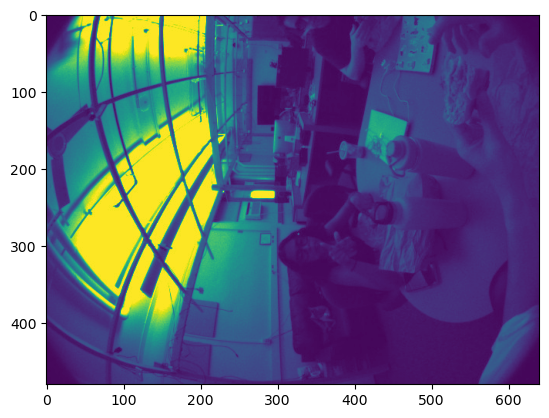

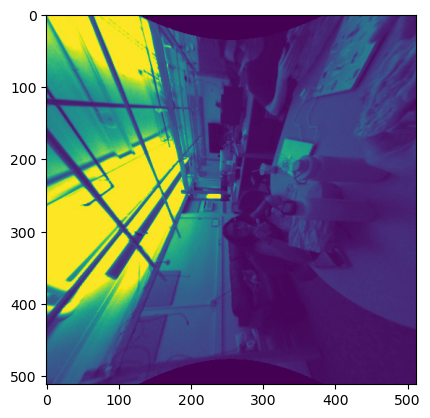

['ARIA_ET_CALIBRATION', 'ARIA_MIC_CALIBRATION', 'BAROMETER_CALIBRATION', 'BarometerCalibration', 'CAMERA_CALIBRATION', 'CameraCalibration', 'CameraModelType', 'CameraProjection', 'DeviceCadExtrinsics', 'DeviceCalibration', 'FISHEYE624', 'IMU_CALIBRATION', 'ImuCalibration', 'KANNALA_BRANDT_K3', 'LINEAR', 'LinearRectificationModel3d', 'MAGNETOMETER_CALIBRATION', 'MICROPHONE_CALIBRATION', 'MagnetometerCalibration', 'MicrophoneCalibration', 'NOT_VALID', 'SPHERICAL', 'SensorCalibration', 'SensorCalibrationType', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'device_calibration_from_json', 'device_calibration_from_json_string', 'distort_by_calibration', 'distort_depth_by_calibration', 'distort_label_by_calibration', 'get_linear_camera_calibration', 'get_spherical_camera_calibration', 'rotate_camera_calib_cw90deg']


In [ ]:
from projectaria_tools.core import data_provider, calibration

camera_label = "camera-slam-left"
stream_id = provider.get_stream_id_from_label(camera_label)

calib = provider.get_device_calibration().get_camera_calib(camera_label)
pinhole = calibration.get_linear_camera_calibration(512, 512, 150)

raw_image = provider.get_image_data_by_index(stream_id, 2000)[0].to_numpy_array()
undistorted_image = calibration.distort_by_calibration(raw_image, pinhole, calib)

#show the raw image
plt.imshow(raw_image)
plt.show()

#show the undistorted image
plt.imshow(undistorted_image)
plt.show()
print(dir(calibration))

In [25]:
import numpy as np

def inverse_warp(marker1, pinhole, cam1_calibration):
    # Convert the pixel coordinate to float and reshape it as needed
    marker1_float = np.array(marker1, dtype=float).reshape(2, 1)  # Reshape to (2, 1)
    
    # Unproject the pixel coordinate using the destination calibration parameters (pinhole)
    ray_dir = pinhole.unproject_no_checks(marker1_float.astype(np.double))
    
    # Project the ray direction onto the source image plane using the source calibration parameters (cam1_calibration)
    maybe_src_pixel = cam1_calibration.project(ray_dir)
    
    if maybe_src_pixel is not None:  # Check if maybe_src_pixel is not None before returning
        return maybe_src_pixel
    
    return None  # Return None if maybe_src_pixel is None or empty

# Example pixel coordinate from the distorted image
marker1_distorted = [100, 150]

# Call the inverseWarp function to find the corresponding pixel in the undistorted image
marker1_undistorted = inverse_warp(marker1_distorted, pinhole, cam1_calibration)

if marker1_undistorted is not None:
    print("Pixel coordinate in the undistorted image:", marker1_undistorted)
else:
    print("Error: Unable to compute the pixel coordinate in the undistorted image.")


Pixel coordinate in the undistorted image: [136.7204997  115.88974198]


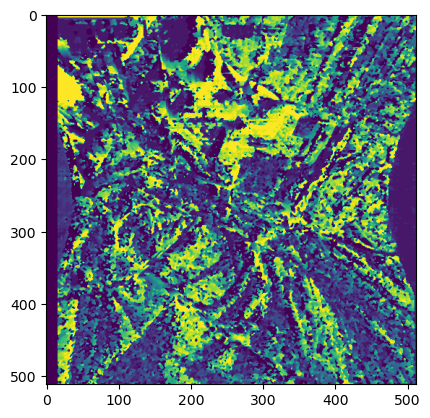

In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load stereo images
img_left = cv2.imread('images/1201-1-1-71.588.jpg', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('images/1201-2-1-71.588.jpg', cv2.IMREAD_GRAYSCALE)

# Perform stereo rectification
# rectify method depends on your calibration data
# Example: cv2.stereoRectifyUncalibrated
# rectified_pair = cv2.stereoRectifyUncalibrated(img_left, img_right, None, None)

# Perform stereo matching to compute disparity map
stereo = cv2.StereoSGBM_create(minDisparity=0, numDisparities=16, blockSize=1)
disparity_map = stereo.compute(img_left, img_right)

# Convert disparity map to 32-bit floating point
disparity_map = disparity_map.astype(np.float32) / 16.0


# Display disparity map
plt.imshow(disparity_map)
plt.show()


In [51]:
import torch
import numpy as np
from transformers import DPTFeatureExtractor, DPTForDepthEstimation

feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")
from PIL import Image
from PIL import ImageDraw

def depth_detect(image):#, point):
    pixel_values = feature_extractor(image, return_tensors="pt").pixel_values
    with torch.no_grad():
        outputs = model(pixel_values)
        predicted_depth = outputs.predicted_depth
    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
                        predicted_depth.unsqueeze(1),
                        size=image.size[::-1],
                        mode="bicubic",
                        align_corners=False,
                ).squeeze()
    output = prediction.cpu().numpy()
    formatted = (output * 255 / np.max(output)).astype('uint8')
    depth = Image.fromarray(formatted)
    #point_depth = output[point]
    
    # Draw a circle around the point
    #draw = ImageDraw.Draw(depth)
    #draw.ellipse((point[0]-5, point[1]-5, point[0]+5, point[1]+5), outline ='red')
    
    return depth#, point_depth


/home/blhohmann/miniconda3/envs/speechviz/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-30 03:53:42.012599: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 03:53:43.033277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/blhohmann/miniconda3/envs/speechviz/lib/python3.10/site-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(

In [78]:
import cv2
import os
import subprocess

import pandas as pd

# Read the CSV file
df = pd.read_csv('faces.csv')
df = df.assign(inside_box=0)
df = df.assign(top_half=0)
df = df.assign(bot_half=0)


def eye_gaze(capture_timestamp_ns,image,slam_stream_label,cam_calibration):
    generalized_eye_gaze = get_nearest_eye_gaze(generalized_eye_gazes, capture_timestamp_ns)
    depth, combined_yaw, combined_pitch = (
        mps.compute_depth_and_combined_gaze_direction(
            generalized_eye_gaze.vergence.left_yaw, generalized_eye_gaze.vergence.right_yaw, generalized_eye_gaze.pitch
        )
    )
    depth_m = depth or 1.0
    generalized_gaze_center_in_pixels = get_gaze_vector_reprojection(generalized_eye_gaze, slam_stream_label, device_calibration, cam_calibration, depth_m)
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    if generalized_gaze_center_in_pixels is not None:
        # Draw a red cross on the image at the gaze center
        marker_position = [(generalized_gaze_center_in_pixels[0]), (generalized_gaze_center_in_pixels[1])]
        return marker_position, image_color
    else:
        print(f"Eye gaze center projected to {generalized_gaze_center_in_pixels}, which is out of camera sensor plane.")
        return None, image_color

output_dir = "images_depth"

slam_stream_id = StreamId("1201-1")
slam_stream_id2 = StreamId("1201-2")

slam_stream_label = provider.get_label_from_stream_id(slam_stream_id)
slam_stream_label2 = provider.get_label_from_stream_id(slam_stream_id2)

num_slam_frames = provider.get_num_data(slam_stream_id)
num_slam_frames = min(num_slam_frames, provider.get_num_data(slam_stream_id2))

slam_frame = provider.get_image_data_by_index(slam_stream_id, (int)(1))
assert slam_frame[0] is not None, "no slam frame"
slam_frame2 = provider.get_image_data_by_index(slam_stream_id2, (int)(1))
assert slam_frame2[0] is not None, "no slam frame"

# get projection function
device_calibration = provider.get_device_calibration()
cam1_calibration = device_calibration.get_camera_calib(slam_stream_label)
cam2_calibration = device_calibration.get_camera_calib(slam_stream_label2)
assert cam1_calibration is not None, "no camera calibration"
assert cam2_calibration is not None, "no camera calibration"

def point_in_box_and_half(x, y, x1, y1, x2, y2):
    # Check if point is in the box
    if (x1 - 5) <= x <= (x2 + 5) and (y1 - 5) <= y <= (y2 + 5):
        # Calculate the midpoint of y1 and y2
        midpoint = (y1 + y2) / 2
        # Check if point is in the top or bottom half
        if y <= midpoint:
            return "Top half"
        else:
            return "Bottom half"
    else:
        return "Outside box"


# Loop over all the frames
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'concat_depth.txt'), 'w') as f:
    with open(os.path.join(output_dir, 'concat_depth2.txt'), 'w') as f2:
        for i in range(1,num_slam_frames):
            slam_frame1 = provider.get_image_data_by_index(slam_stream_id, (int)(i))
            slam_frame2 = provider.get_image_data_by_index(slam_stream_id2, (int)(i))

            image1 = slam_frame1[0].to_numpy_array()
            image2 = slam_frame2[0].to_numpy_array()
            
            pinhole = calibration.get_linear_camera_calibration(512, 512, 150)
            
            capture_timestamp_ns_1 = slam_frame1[1].capture_timestamp_ns
            capture_timestamp_ns_2 = slam_frame2[1].capture_timestamp_ns
            
            time1 = capture_timestamp_ns_1 / 1e9
            time2 = capture_timestamp_ns_2 / 1e9


            eye_gaze1 = eye_gaze(capture_timestamp_ns_1,image1,slam_stream_label,cam1_calibration)
            eye_gaze2 = eye_gaze(capture_timestamp_ns_2,image2,slam_stream_label2,cam2_calibration)

            image1 = eye_gaze1[1]
            marker1 = eye_gaze1[0]
            #print(marker1)

            image2 = eye_gaze2[1]
            marker2 = eye_gaze2[0]
            #print(marker2)

            #undistorted_image1 = calibration.distort_by_calibration(image1, pinhole, cam1_calibration)
            #undistorted_image2 = calibration.distort_by_calibration(image2, pinhole, cam2_calibration)

            image_height, image_width = image1.shape[:2]
            image_height2, image_width2 = image2.shape[:2]

            image1_pil = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
            # Convert the image to PIL format
            image1_pil = Image.fromarray(image1_pil)
            # Perform depth detection
            depth_map = image1_pil#depth_map = depth_detect(image1_pil)

            image2_pil = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
            # Convert the image to PIL format
            image2_pil = Image.fromarray(image2_pil)
            # Perform depth detection
            depth_map2 = image2_pil#depth_map2 = depth_detect(image2_pil)

            depth_height, depth_width = depth_map.size
            old_width, old_height = image_width, image_height
            new_width, new_height = depth_width, depth_height

            depth_map = np.array(depth_map)
            heatmap = cv2.applyColorMap(depth_map, cv2.COLORMAP_JET)
            depth_map2 = np.array(depth_map2)
            heatmap2 = cv2.applyColorMap(depth_map2, cv2.COLORMAP_JET)
            #print(i)
            #print(marker1)

            if marker1 is not None:
                cv2.drawMarker(heatmap, [int(marker1[0]),int(marker1[1])], color=(255, 255, 255), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=3)
            if marker2 is not None:
                cv2.drawMarker(heatmap2, [int(marker2[0]),int(marker2[1])], color=(255, 255, 255), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=3)

            filtered_df = df[df['frameNum'] == i]

            # Write the depth text on the rotated image
            undistorted_image1_rotated = cv2.rotate(heatmap, cv2.ROTATE_90_CLOCKWISE)
            undistorted_image2_rotated = cv2.rotate(heatmap2, cv2.ROTATE_90_CLOCKWISE)

            # Check if there are any rows for the given frameNum
            if not filtered_df.empty:
                for index, row in filtered_df.iterrows():
                    x1 = row['x1']
                    y1 = row['y1']
                    x2 = row['x2']
                    y2 = row['y2']
                    cv2.rectangle(undistorted_image1_rotated, (x1, y1), (x2, y2), (0, 255, 0), 5)
                    if marker1 is not None:
                        image_height, image_width = undistorted_image1_rotated.shape[:2]
                        #print(image_height, image_width)
                        rotated_x, rotated_y = image_width - marker1[1], marker1[0]
                        # if i == 16:
                        #     print(marker1[0], marker1[1])
                        #     print(rotated_x, rotated_y)
                        #     print(x1, y1, x2, y2)

                        result = point_in_box_and_half(rotated_x, rotated_y, x1, y1, x2, y2)
                        if result in ["Top half", "Bottom half"]:
                            df.loc[df['frameNum'] == i, 'inside_box'] = 1
                        if result in ["Top half"]:
                            df.loc[df['frameNum'] == i, 'top_half'] = 1
                        if result in ["Bottom half"]:
                            df.loc[df['frameNum'] == i, 'bot_half'] = 1
                        cv2.putText(undistorted_image1_rotated, result, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
                        print(i, ": ", result)
                    else:
                        cv2.putText(undistorted_image1_rotated, "Outside box", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
                        print(i, ": ", "Outside (technically)")

            # Save the images
            #cv2.imwrite(os.path.join(output_dir, f'depth_1201-1-{i}-{time1:.3f}.jpg'), undistorted_image1_rotated)
            #cv2.imwrite(os.path.join(output_dir, f'depth_1201-2-{i}-{time2:.3f}.jpg'), undistorted_image2_rotated)

            f.write(f'file depth_1201-1-{i}-{time1:.3f}.jpg\n')
            f2.write(f'file depth_1201-2-{i}-{time2:.3f}.jpg\n')
            # Convert the image from BGR to RGB

            # Display the image
            # plt.imshow(heatmap)
            # plt.show()
            # break
            
df.to_csv('faces.csv', index=False)
# # if output.mp4 exists delete it
# if os.path.exists('output_depth.mp4'):
#     os.remove('output_depth.mp4')
# if os.path.exists('output_depth2.mp4'):
#     os.remove('output_depth2.mp4')
# # Use ffmpeg to create the video with 10 fps
# subprocess.run(['ffmpeg', '-r', '10', '-f', 'concat', '-safe', '0', '-i', os.path.join(output_dir, 'concat_depth.txt'), '-c:v', 'libx264', '-pix_fmt', 'yuv420p', 'output_depth.mp4'])
# subprocess.run(['ffmpeg', '-r', '10', '-f', 'concat', '-safe', '0', '-i', os.path.join(output_dir, 'concat_depth2.txt'), '-c:v', 'libx264', '-pix_fmt', 'yuv420p', 'output_depth2.mp4'])

5 :  Top half
6 :  Top half
7 :  Top half
8 :  Top half
9 :  Top half
10 :  Top half
11 :  Top half
12 :  Top half
13 :  Top half
14 :  Top half
15 :  Top half
16 :  Top half
78 :  Outside box
Eye gaze center projected to None, which is out of camera sensor plane.
Eye gaze center projected to None, which is out of camera sensor plane.
83 :  Outside (technically)
84 :  Outside box
85 :  Outside box
Eye gaze center projected to None, which is out of camera sensor plane.
Eye gaze center projected to None, which is out of camera sensor plane.
Eye gaze center projected to None, which is out of camera sensor plane.
Eye gaze center projected to None, which is out of camera sensor plane.
Eye gaze center projected to None, which is out of camera sensor plane.
Eye gaze center projected to None, which is out of camera sensor plane.
Eye gaze center projected to None, which is out of camera sensor plane.
Eye gaze center projected to None, which is out of camera sensor plane.
Eye gaze center project

In [76]:
if os.path.exists('output_combined_depth.mp4'):
    os.remove('output_combined_depth.mp4')
subprocess.run(['ffmpeg', 
                '-i', 'output_depth.mp4', 
                '-i', 'output_depth2.mp4', 
                '-filter_complex', '[0:v][1:v]hstack=inputs=2[v]', 
                '-map', '[v]', 
                '-c:v', 'libx264', 
                '-crf', '23', 
                '-pix_fmt', 'yuv420p', 
                'output_combined_depth.mp4'])

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


frame= 3633 fps=132 q=-1.0 Lsize=   51425kB time=00:06:03.00 bitrate=1160.5kbits/s speed=13.2x    
video:51393kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.061786%
[libx264 @ 0x55e23874b400] frame I:269   Avg QP:18.84  size: 22228
[libx264 @ 0x55e23874b400] frame P:2389  Avg QP:21.74  size: 14714
[libx264 @ 0x55e23874b400] frame B:975   Avg QP:22.01  size: 11789
[libx264 @ 0x55e23874b400] consecutive B-frames: 54.2% 27.1%  9.2%  9.6%
[libx264 @ 0x55e23874b400] mb I  I16..4: 37.6% 57.4%  5.0%
[libx264 @ 0x55e23874b400] mb P  I16..4: 28.4% 34.6%  1.4%  P16..4: 24.2%  8.1%  2.0%  0.0%  0.0%    skip: 1.3%
[libx264 @ 0x55e23874b400] mb B  I16..4: 14.1% 17.7%  0.5%  B16..8: 36.5% 10.5%  0.9%  direct: 8.3%  skip:11.5%  L0:55.3% L1:41.7% BI: 3.0%
[libx264 @ 0x55e23874b400] 8x8 transform intra:54.3% inter:91.5%
[libx264 @ 0x55e23874b400] coded y,uvDC,uvAC intra: 23.9% 91.6% 37.1% inter: 21.8% 62.7% 10.2%
[libx264 @ 0x55e23874b400] i16 v,h,dc,p:  9% 25%  3% 62

CompletedProcess(args=['ffmpeg', '-i', 'output_depth.mp4', '-i', 'output_depth2.mp4', '-filter_complex', '[0:v][1:v]hstack=inputs=2[v]', '-map', '[v]', '-c:v', 'libx264', '-crf', '23', '-pix_fmt', 'yuv420p', 'output_combined_depth.mp4'], returncode=0)

In [47]:
import cv2
import os
import subprocess

def eye_gaze(capture_timestamp_ns,image,slam_stream_label,cam_calibration):
    generalized_eye_gaze = get_nearest_eye_gaze(generalized_eye_gazes, capture_timestamp_ns)
    depth, combined_yaw, combined_pitch = (
        mps.compute_depth_and_combined_gaze_direction(
            generalized_eye_gaze.vergence.left_yaw, generalized_eye_gaze.vergence.right_yaw, generalized_eye_gaze.pitch
        )
    )
    depth_m = depth or 1.0
    generalized_gaze_center_in_pixels = get_gaze_vector_reprojection(generalized_eye_gaze, slam_stream_label, device_calibration, cam_calibration, depth_m)
    if len(image.shape) == 2 or image.shape[2] == 1:
        # The image is grayscale, convert it to color
        image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        # The image is already in color, no need to convert
        image_color = image
    if generalized_gaze_center_in_pixels is not None:
        # Draw a red cross on the image at the gaze center
        marker_position = [(generalized_gaze_center_in_pixels[0]), (generalized_gaze_center_in_pixels[1])]
        return marker_position, image_color
    else:
        print(f"Eye gaze center projected to {generalized_gaze_center_in_pixels}, which is out of camera sensor plane.")
        return None, image_color

import numpy as np

def inverse_warp(marker1, pinhole, cam1_calibration):
    # Convert the pixel coordinate to float and reshape it as needed
    marker1_float = np.array(marker1, dtype=float).reshape(2, 1)  # Reshape to (2, 1)
    
    # Unproject the pixel coordinate using the destination calibration parameters (pinhole)
    ray_dir = pinhole.unproject_no_checks(marker1_float.astype(np.double))
    
    # Project the ray direction onto the source image plane using the source calibration parameters (cam1_calibration)
    maybe_src_pixel = cam1_calibration.project(ray_dir)
    
    if maybe_src_pixel is not None:  # Check if maybe_src_pixel is not None before calling .any()
        if maybe_src_pixel.any():  # Check if any elements are non-zero or non-empty
            # Convert the projected pixel coordinate back to float and reshape it as needed
            src_pixel_float = maybe_src_pixel.astype(float).reshape(2,)  # Reshape to (2,)
            return src_pixel_float
    
    return None  # Return None if maybe_src_pixel is None or empty

def correct_point(green_point, red_point):
    green_point = np.array(green_point)
    red_point = np.array(red_point)
    
    # Calculate the direction vector from green to red
    direction_vector = red_point - green_point
    
    # Calculate the distance between green and red points
    distance = np.linalg.norm(direction_vector)
    
    # Normalize the direction vector
    unit_vector = direction_vector / distance
    
    # Extend the green point along the direction vector by the same distance
    corrected_point = red_point + unit_vector * distance
    
    return corrected_point


output_dir = "images"

slam_stream_id = StreamId("1201-1")
slam_stream_id2 = StreamId("1201-2")

slam_stream_label = provider.get_label_from_stream_id(slam_stream_id)
slam_stream_label2 = provider.get_label_from_stream_id(slam_stream_id2)

num_slam_frames = provider.get_num_data(slam_stream_id)
num_slam_frames = min(num_slam_frames, provider.get_num_data(slam_stream_id2))

slam_frame = provider.get_image_data_by_index(slam_stream_id, (int)(1))
assert slam_frame[0] is not None, "no slam frame"
slam_frame2 = provider.get_image_data_by_index(slam_stream_id2, (int)(1))
assert slam_frame2[0] is not None, "no slam frame"

# get projection function
device_calibration = provider.get_device_calibration()
cam1_calibration = device_calibration.get_camera_calib(slam_stream_label)
cam2_calibration = device_calibration.get_camera_calib(slam_stream_label2)
assert cam1_calibration is not None, "no camera calibration"
assert cam2_calibration is not None, "no camera calibration"


# Loop over all the frames
os.makedirs(output_dir, exist_ok=True)
with open(os.path.join(output_dir, 'concat.txt'), 'w') as f:
    with open(os.path.join(output_dir, 'concat2.txt'), 'w') as f2:
        for i in range(1,num_slam_frames):
            slam_frame1 = provider.get_image_data_by_index(slam_stream_id, (int)(i))
            slam_frame2 = provider.get_image_data_by_index(slam_stream_id2, (int)(i))

            image1 = slam_frame1[0].to_numpy_array()
            image2 = slam_frame2[0].to_numpy_array()
            
            pinhole = calibration.get_linear_camera_calibration(512, 512, 150)
            
            capture_timestamp_ns_1 = slam_frame1[1].capture_timestamp_ns
            capture_timestamp_ns_2 = slam_frame2[1].capture_timestamp_ns
            
            time1 = capture_timestamp_ns_1 / 1e9
            time2 = capture_timestamp_ns_2 / 1e9


            eye_gaze1 = eye_gaze(capture_timestamp_ns_1,image1,slam_stream_label,cam1_calibration)
            eye_gaze2 = eye_gaze(capture_timestamp_ns_2,image2,slam_stream_label2,cam2_calibration)

            image1 = eye_gaze1[1]
            marker1 = eye_gaze1[0]
            print(marker1)

            image2 = eye_gaze2[1]
            marker2 = eye_gaze2[0]
            print(marker2)

            if  marker1 is not None:
                marker1int = [int(marker1[0]), int(marker1[1])]
                cv2.drawMarker(image1, marker1int, color=(255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=3)
            
            if  marker2 is not None:
                marker2int = [int(marker2[0]), int(marker2[1])]
                cv2.drawMarker(image2, marker2int, color=(255, 0, 0), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=3)

            undistorted_image1 = calibration.distort_by_calibration(image1, pinhole, cam1_calibration)
            undistorted_image2 = calibration.distort_by_calibration(image2, pinhole, cam2_calibration)
            
            new_eye_gaze1 = eye_gaze(capture_timestamp_ns_1,image1,slam_stream_label,pinhole)
            new_eye_gaze2 = eye_gaze(capture_timestamp_ns_2,image2,slam_stream_label2,pinhole)
            new_marker1 = new_eye_gaze1[0]
            new_marker2 = new_eye_gaze2[0]

            (new_x, new_y, new_x2, new_y2) = (0,0,0,0)

            if new_marker1 is not None:
                [new_x, new_y] = new_marker1
                cv2.drawMarker(undistorted_image1, [int(new_x),int(new_y)], color=(255, 255, 0), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=3)

            if  new_marker2 is not None:
                [new_x2, new_y2] = new_marker2
                cv2.drawMarker(undistorted_image2, [int(new_x2),int(new_y2)], color=(255, 255, 0), markerType=cv2.MARKER_CROSS, markerSize=20, thickness=3)


            depth = -1.00

            def rotate_text_position(text_position, angle, image_shape):
                # Convert the text position to the center of the text box
                text_center = (text_position[0], text_position[1])

                # Calculate the rotation matrix
                rotation_matrix = cv2.getRotationMatrix2D(text_center, angle, 1.0)

                # Apply the rotation matrix to the text position
                rotated_position = np.dot(rotation_matrix, np.array([text_position[0], text_position[1], 1]))
                return (int(rotated_position[0]), int(rotated_position[1]))

            if new_marker1 is not None and new_marker2 is not None:
                # Calculate depth
                depth = distance_stereo(new_x, new_y, new_x2, new_y2)
                print(i, depth)

            # Add the depth as text in the top left corner of the image
            depth_text = f"Depth: {depth:.2f} meters"
            text_position = (10, 30)  # Top left corner

            # Rotate the text position to counter the image rotation
            rotated_text_position = rotate_text_position(text_position, -90, undistorted_image1.shape)

            # Write the depth text on the rotated image
            undistorted_image1_rotated = cv2.rotate(undistorted_image1, cv2.ROTATE_90_CLOCKWISE)
            undistorted_image2_rotated = cv2.rotate(undistorted_image2, cv2.ROTATE_90_CLOCKWISE)

            cv2.putText(undistorted_image1_rotated, depth_text, rotated_text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
            cv2.putText(undistorted_image2_rotated, depth_text, rotated_text_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

            # Save the images
            cv2.imwrite(os.path.join(output_dir, f'1201-1-{i}-{time1:.3f}.jpg'), undistorted_image1_rotated)
            cv2.imwrite(os.path.join(output_dir, f'1201-2-{i}-{time2:.3f}.jpg'), undistorted_image2_rotated)

            f.write(f'file 1201-1-{i}-{time1:.3f}.jpg\n')
            f2.write(f'file 1201-2-{i}-{time2:.3f}.jpg\n')
            # Convert the image from BGR to RGB

            # Display the image
            #plt.imshow(image_color)
            #plt.show()
            #break
            
# if output.mp4 exists delete it
if os.path.exists('output.mp4'):
    os.remove('output.mp4')
if os.path.exists('output2.mp4'):
    os.remove('output2.mp4')
# Use ffmpeg to create the video with 10 fps
subprocess.run(['ffmpeg', '-r', '10', '-f', 'concat', '-safe', '0', '-i', os.path.join(output_dir, 'concat.txt'), '-c:v', 'libx264', '-pix_fmt', 'yuv420p', 'output.mp4'])
subprocess.run(['ffmpeg', '-r', '10', '-f', 'concat', '-safe', '0', '-i', os.path.join(output_dir, 'concat2.txt'), '-c:v', 'libx264', '-pix_fmt', 'yuv420p', 'output2.mp4'])

[356.90575209098705, 66.00347393537072]
[356.4183882680798, 403.8036140049589]
1 1.6647652698481992
[356.90575209098705, 66.00347393537072]
[356.4183882680798, 403.8036140049589]
2 1.6647652698481992
[355.84122431580664, 68.1448217035852]
[355.4779392168111, 403.5405369416194]
3 1.8790128564793542
[355.84122431580664, 68.1448217035852]
[355.4779392168111, 403.5405369416194]
4 1.8790128564793542
[361.4857500126524, 64.1719878568052]
[360.91526732997477, 404.80961801001376]
5 1.434630901626053
[361.4857500126524, 64.1719878568052]
[360.91526732997477, 404.80961801001376]
6 1.434630901626053
[361.6313938501592, 69.69922861301828]
[362.0259658587463, 411.91427538962307]
7 1.3454785021284301
[360.97875274515326, 75.86284729573245]
[361.9205676773965, 413.3089640003793]
8 1.6208360217170865
[360.97875274515326, 75.86284729573245]
[361.9205676773965, 413.3089640003793]
9 1.6208360217170865
[359.37868436149995, 80.70417734751649]
[360.3241461190569, 409.25616630326385]
10 2.7142276008734596
[3

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


CompletedProcess(args=['ffmpeg', '-r', '10', '-f', 'concat', '-safe', '0', '-i', 'images/concat2.txt', '-c:v', 'libx264', '-pix_fmt', 'yuv420p', 'output2.mp4'], returncode=0)

In [48]:
if os.path.exists('output_combined.mp4'):
    os.remove('output_combined.mp4')
subprocess.run(['ffmpeg', 
                '-i', 'output.mp4', 
                '-i', 'output2.mp4', 
                '-filter_complex', '[0:v][1:v]hstack=inputs=2[v]', 
                '-map', '[v]', 
                '-c:v', 'libx264', 
                '-crf', '23', 
                '-pix_fmt', 'yuv420p', 
                'output_combined.mp4'])

ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


CompletedProcess(args=['ffmpeg', '-i', 'output.mp4', '-i', 'output2.mp4', '-filter_complex', '[0:v][1:v]hstack=inputs=2[v]', '-map', '[v]', '-c:v', 'libx264', '-crf', '23', '-pix_fmt', 'yuv420p', 'output_combined.mp4'], returncode=0)